In [2]:
import abc
from typing import Callable
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import functools
import cvxpy as cp

## Problem 1
Set the Crazyflie dynamics class below

In [3]:
class Dynamics(metaclass=abc.ABCMeta):
    dynamics_func: Callable
    state_dim: int
    control_dim: int

    def __init__(self, dynamics_func, state_dim, control_dim):
        self.dynamics_func = dynamics_func
        self.state_dim = state_dim
        self.control_dim = control_dim

    def __call__(self, state, control, time=0):
        return self.dynamics_func(state, control, time)

In [5]:
def quadcopter_ode(state, control, time):
    '''
    Quadcopter dynamics:
    state = [x, y, z, phi, theta, psi, x_dot, y_dot, z_dot, phi_dot, theta_dot, psi_dot]
    control = [w1, w2, w3, w4, T]
    '''

    # Constants (assume defined, or pass them in if needed)
    m = 1.0       # mass
    g = 9.81      # gravity
    k = 1.0       # thrust coefficient
    b = 0.1       # drag coefficient
    l = 0.25      # arm length
    Ix = 0.01     # moment of inertia x
    Iy = 0.01     # moment of inertia y
    Iz = 0.02     # moment of inertia z
    c = jnp.sqrt(2) / 2  # cos(pi/4) = sin(pi/4)

    # Unpack state
    x, y, z, phi, theta, psi, x_dot, y_dot, z_dot, phi_dot, theta_dot, psi_dot = state
    w1, w2, w3, w4, T = control

    # Translational accelerations
    x_ddot = (T / m) * (jnp.cos(psi) * jnp.sin(theta) * jnp.cos(phi) + jnp.sin(psi) * jnp.sin(phi))
    y_ddot = (T / m) * (jnp.sin(psi) * jnp.sin(theta) * jnp.cos(phi) - jnp.cos(psi) * jnp.sin(phi))
    z_ddot = (T / m) * (jnp.cos(theta) * jnp.cos(phi)) - g

    # Rotational accelerations
    phi_ddot = (k * l / Ix) * (-w1**2 + w2**2 + w3**2 - w4**2) * c
    theta_ddot = (k * l / Iy) * (-w1**2 - w2**2 + w3**2 - w4**2) * c
    psi_ddot = (b / Iz) * (w1**2 - w2**2 + w3**2 - w4**2)

    # Return state derivative
    return jnp.array([
        x_dot, y_dot, z_dot,
        phi_dot, theta_dot, psi_dot,
        x_ddot, y_ddot, z_ddot,
        phi_ddot, theta_ddot, psi_ddot
    ])
    
# Instantiate the dynamics
state_dim = 12
control_dim = 5
continuous_dynamics = Dynamics(quadcopter_ode, state_dim, control_dim)

### (b) Obtaining discrete-time dynamics

With the continuous time dynamics, we can obtain the discrete time dynamics by integrating over a time step $\Delta t$.

Implement both Euler integation and Runge-Kutta integration to obtain the discrete-time dynamics.

In [6]:
def euler_integrate(dynamics, dt):
    # zero-order hold
    def integrator(x, u, t):
        dx = dynamics(x,u,t)
        return jnp.array(x+dt*dx) # computes x(k+1) using euler inteegration x(k+1) = dx(k)*dt + x(k)

    return integrator

def runge_kutta_integrator(dynamics, dt=0.1):
    # zero-order hold
    def integrator(x, u, t):
        k1 = dynamics(x,u,t)
        k2 = dynamics(x + 0.5*dt*k1, u, t+0.5*dt)
        k3 = dynamics(x + 0.5*dt*k2, u, t+0.5*dt)
        k4 = dynamics(x + dt*k3, u, t+dt)
        
        return jnp.array(x + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)) # computes x(k+1) using RK4 integration

    return integrator

In [7]:
# example usage of the integrators

dt = 0.1 # timestep size

discrete_dynamics_euler = Dynamics(
    euler_integrate(continuous_dynamics, dt), state_dim, control_dim
)
discrete_dynamics_rk = Dynamics(
    runge_kutta_integrator(continuous_dynamics, dt), state_dim, control_dim
)

### (c) Simulating dynamics

Simulate your dynamics over 5 seconds for different values of $\Delta t$ and compare the trajectories. 

Show on the same plot, the simulated trajectories for the following cases:
- Discrete-time dynamics with Euler integration, $\Delta t = 0.01$
- Discrete-time dynamics with Euler integration, $\Delta t = 0.5$
- Discrete-time dynamics with RK integration, $\Delta t = 0.01$
- Discrete-time dynamics with RK integration, $\Delta t = 0.5$


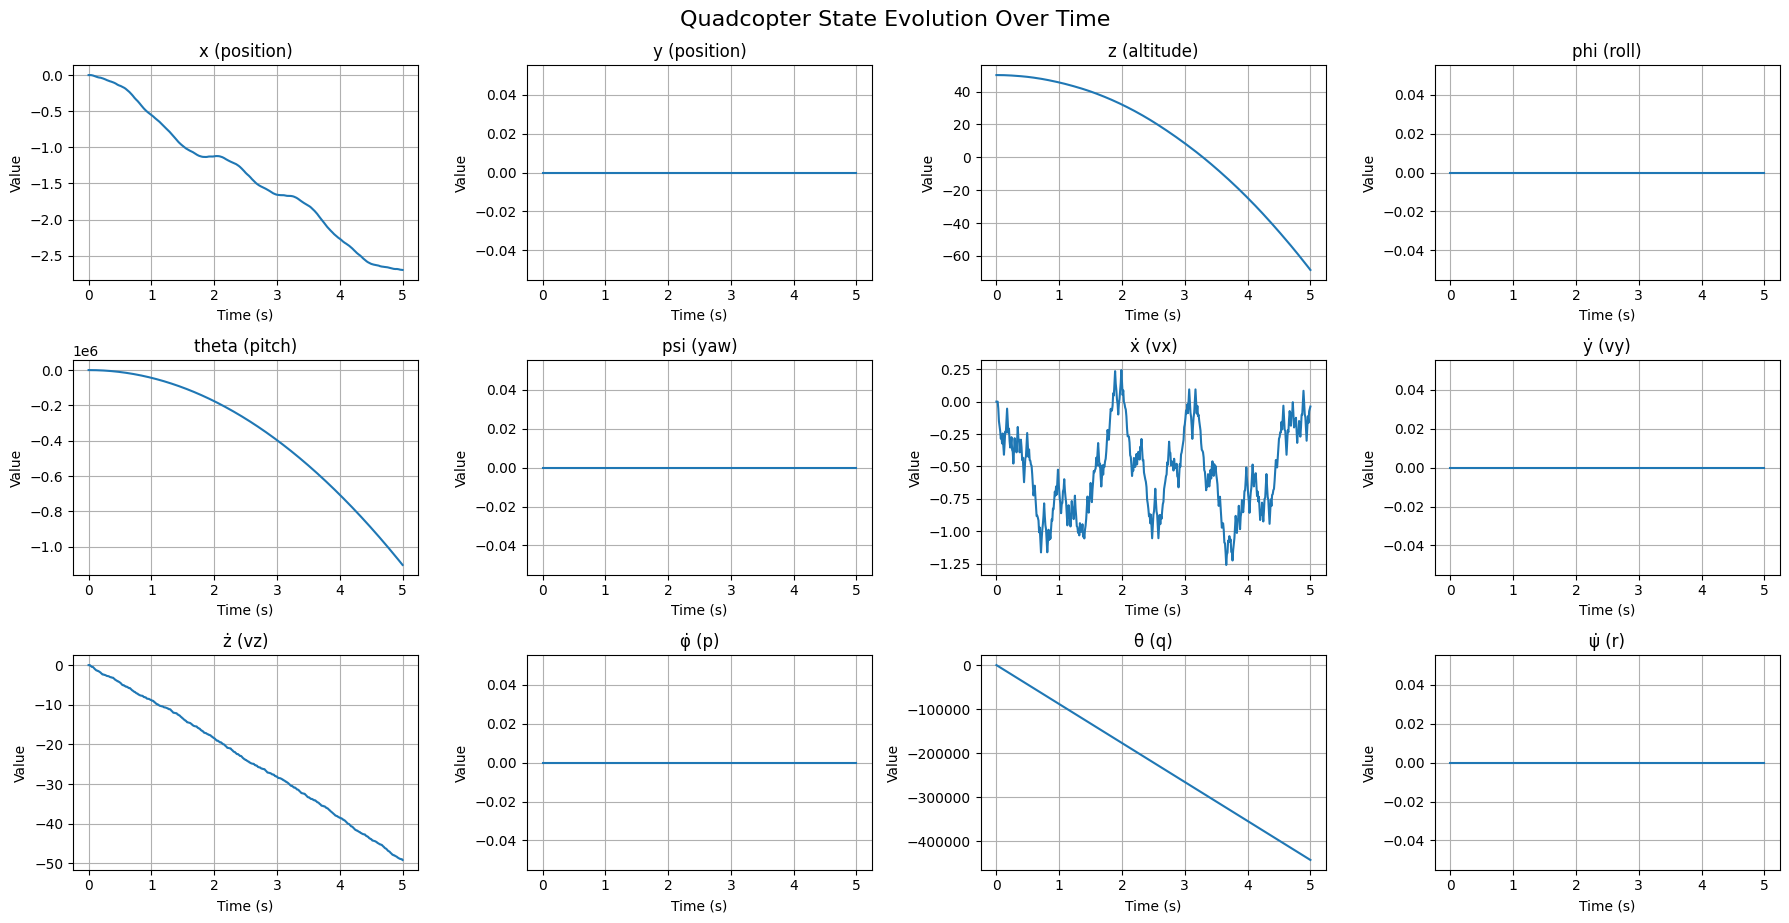

In [16]:
def simulate(dynamics, initial_state, controls, dt):
    
   #  Propagates states through the dynamics using the control sequence, starting at initial_state.
    
   # Args:
   #     dynamics: A function that takes in a state and control, and returns the next state.
   #     initial_state: A jax.numpy array of size (n,) representing the initial state.
   #     controls: A jax.numpy array of size (T, m), where T is the number of control inputs.
   #     dt: A scalar that represents the time step for integration (important for Euler and Runge-Kutta methods).
   # Returns:
   #     A jax.numpy array of size (T+1, n), representing the sequence of states over time, including the initial state and the state at each time step.

   #  Initialize the state list with the initial state
    trajectory = [initial_state]
    state = initial_state

    # Iterate through the control sequence and compute the next state at each step
    for u in controls:
        state = dynamics(state, u, dt)  # Get next state from dynamics
        trajectory.append(state)  # Append new state to the trajectory list
    
    # Stack the trajectory list into a jnp array of shape (T+1, n)
    return jnp.stack(trajectory)

# code to loop over the different integrators and step sizes
# and plot the corresponding trajectories

initial_state = jnp.array([0.0, 0.0, 50.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
# Example control input: hover (equal rotor speeds, upward thrust to balance gravity)
w_hover = 50.0  # Example value
T_hover = 9.81  # Assuming T/m = g
control= jnp.array([w_hover, w_hover, w_hover, w_hover, T_hover])
#control = jnp.array([10.0, 1.0, 1.0, 1.0, 100.0])  # constant control over the 5 second duration.
duration = 5.0
#dts = [0.01, 0.5]
dts = [0.01]

for dt in dts:
    num_steps = int(duration / dt)
    controls = [control] * num_steps
    
    # construct the discrete dynamics for given timestep
    discrete_dynamics_euler = Dynamics(euler_integrate(continuous_dynamics, dt), state_dim, control_dim)
    #discrete_dynamics_rk = Dynamics(runge_kutta_integrator(continuous_dynamics, dt), state_dim, control_dim)
    
    # simulate dynamics
    xs_euler = simulate(discrete_dynamics_euler, initial_state, controls, dt)
    #xs_rk = simulate(discrete_dynamics_rk, initial_state, controls, dt)
    
     # Time vector
    time_points = jnp.linspace(0, duration, num_steps + 1)

    # Extract x, y, z
    x_traj = xs_euler[:, 0]
    y_traj = xs_euler[:, 1]
    z_traj = xs_euler[:, 2]

    # plot the trajectories
   # plt.plot(xs_euler[:, 0], xs_euler[:, 1], label=f"dt = {dt} Euler")
   # plt.plot(xs_rk[:, 0], xs_rk[:, 1], label=f"dt = {dt} RK")
   # plt.legend()
    
    # Label each state variable
state_labels = [
    "x (position)", "y (position)", "z (altitude)",
    "phi (roll)", "theta (pitch)", "psi (yaw)",
    "ẋ (vx)", "ẏ (vy)", "ż (vz)",
    "φ̇ (p)", "θ̇ (q)", "ψ̇ (r)"
]

time_points = jnp.linspace(0, duration, xs_euler.shape[0])

# Plot all 12 states in a 3x4 grid
fig, axes = plt.subplots(3, 4, figsize=(18, 9))
axes = axes.flatten()

for i in range(12):
    axes[i].plot(time_points, xs_euler[:, i])
    axes[i].set_title(state_labels[i])
    axes[i].set_xlabel("Time (s)")
    axes[i].set_ylabel("Value")
    axes[i].grid(True)

plt.tight_layout()
plt.suptitle("Quadcopter State Evolution Over Time", fontsize=16, y=1.02)
plt.show()